<a href="https://colab.research.google.com/github/sheelapravalika/sheela2000.drdo/blob/main/SLM(2)_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



✅ Accuracy: 97.05%
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      6669
           1       0.97      1.00      0.99      6669
           2       0.97      0.98      0.98      6669
           3       0.94      0.98      0.96      6669
           4       0.97      0.91      0.94      6669
           5       0.96      0.94      0.95      6669
           6       0.94      0.99      0.96      6669
           7       1.00      1.00      1.00      6669
           8       0.98      0.99      0.98      6669
           9       1.00      1.00      1.00      6668
          10       0.97      1.00      0.98      6668
          11       0.99      1.00      1.00      6669

    accuracy                           0.97     80026
   macro avg       0.97      0.97      0.97     80026
weighted avg       0.97      0.97      0.97     80026



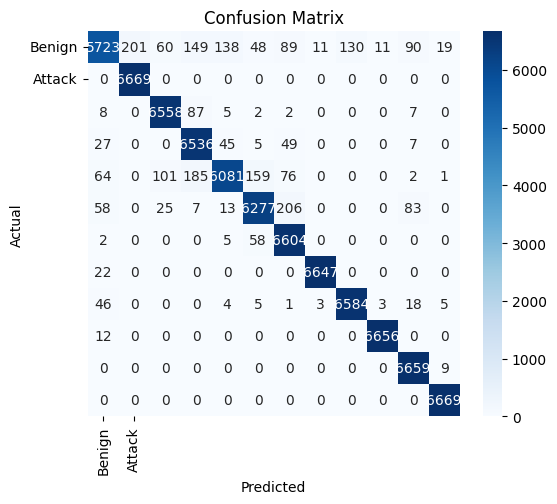

In [ ]:
# ✅ STEP 1: Install required packages
!pip install -q datasets sentence-transformers scikit-learn imbalanced-learn matplotlib seaborn

# ✅ STEP 2: Import libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ STEP 3: Load dataset from HuggingFace
dataset = load_dataset("sonnh-tech1/cic-ids-2017", "binary")
df = dataset["train"].to_pandas()

# ✅ STEP 4: Convert Label to string (prevent dtype issues)
if df["Label"].dtype != "object":
    df["Label"] = df["Label"].astype(str)

# ✅ STEP 5: Keep numeric + label columns
df = df.select_dtypes(include=[np.number]).copy()
df["Label"] = dataset["train"]["Label"]  # Ensure label is present

# ✅ STEP 6: Sample 40k records to fit Colab CPU
df = df.sample(n=40000, random_state=42).reset_index(drop=True)

# ✅ STEP 7: Drop NA
df.dropna(inplace=True)

# ✅ STEP 8: Split features and labels
X = df.drop(columns=["Label"], errors='ignore')
y = LabelEncoder().fit_transform(df["Label"])

# ✅ STEP 9: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ STEP 10: Convert scaled numeric rows into text for MiniLM
text_data = pd.DataFrame(X_scaled).astype(str).agg(' '.join, axis=1).tolist()

# ✅ STEP 11: Generate sentence embeddings
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Better than L3-v2
X_embed = model.encode(text_data, batch_size=16, show_progress_bar=True)

# ✅ STEP 12: SMOTE to balance class distribution
X_bal, y_bal = SMOTE(random_state=42).fit_resample(X_embed, y)

# ✅ STEP 13: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# ✅ STEP 14: Train Logistic Regression on sentence embeddings
clf = LogisticRegression(max_iter=100, C=1.0, class_weight='balanced', solver='lbfgs')
clf.fit(X_train, y_train)

# ✅ STEP 15: Evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("✅ Classification Report:\n", classification_report(y_test, y_pred))

# ✅ STEP 16: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = ["Benign", "Attack"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
